## Setup


In [41]:
import tensorflow as tf
import keras
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.20.0


## Load dataset

In [42]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

## Build model

In [43]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation="softmax")
])
model.output_names=['output']

/home/lea/Documents/work/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train

In [44]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs = 2,
    validation_data=(x_val, y_val),
)
history.history

Epoch 1/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3831 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.1740 - val_sparse_categorical_accuracy: 0.9510
Epoch 2/2
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.1425 - val_sparse_categorical_accuracy: 0.9598


{'loss': [0.3831275701522827, 0.1856287717819214],
 'sparse_categorical_accuracy': [0.8907600045204163, 0.9449599981307983],
 'val_loss': [0.17396728694438934, 0.1424650102853775],
 'val_sparse_categorical_accuracy': [0.9509999752044678, 0.9598000049591064]}

## Evaluate

In [45]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)


Evaluate on test data
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1479 - sparse_categorical_accuracy: 0.9555
test loss, test acc: [0.1478782296180725, 0.9555000066757202]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
predictions shape: (3, 10)


## Predictions

[]

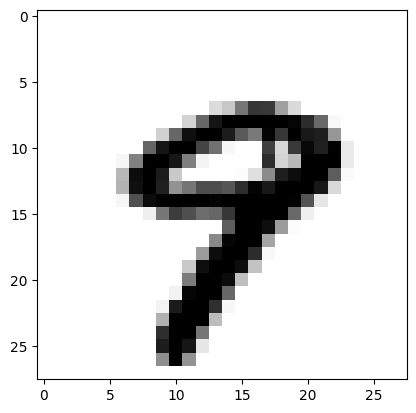

In [56]:
import matplotlib.pyplot as plt
import numpy as np

sample = x_test[9:10]
image = sample[0]
plt.imshow(image, cmap='gray_r')
plt.plot()

In [57]:
prediction = model.predict(sample)
prediction[0].argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


np.int64(9)

## Convert to ONNX

In [48]:
import tf2onnx
import onnx

onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "model.onnx")

I0000 00:00:1768217182.835186   14145 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1768217182.835351   14145 single_machine.cc:376] Starting new session
I0000 00:00:1768217182.870495   14145 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1768217182.870643   14145 single_machine.cc:376] Starting new session
rewriter <function rewrite_constant_fold at 0x74049c4f2200>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


## Export sample

In [58]:
with open("sample.c", 'a') as file:
    file.write("const float sample[1][28][28] = {{")

    for i in range(27):
        string_with_seperator = ','.join(sample[0][i].astype(str))
        file.write("{")
        file.write(string_with_seperator)
        file.write("},\n")

    string_with_seperator = ','.join(sample[0][i].astype(str))
    file.write("{")
    file.write(string_with_seperator)
    file.write("}")

    file.write("}};")
        

## Convert model to TFLite

In [61]:
model.export("keras_model")
converter = tf.lite.TFLiteConverter.from_saved_model("keras_model")
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: keras_model/assets


INFO:tensorflow:Assets written to: keras_model/assets


Saved artifact at 'keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  127563197405456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127563197411024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127563197402576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127563197407376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127563197399312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  127563197404304: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1768229828.098775   14145 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768229828.098804   14145 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2026-01-12 15:57:08.101355: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: keras_model
2026-01-12 15:57:08.102408: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2026-01-12 15:57:08.102422: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: keras_model
I0000 00:00:1768229828.108254   14145 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2026-01-12 15:57:08.109485: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2026-01-12 15:57:08.137305: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: keras_model
2026-01-12 15:57:08.145882: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags {